## 1. Set Up The Environment

In [1]:
import pandas as pd
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import mafuncs as ma

## 2. Pull Data From Our SQL Table into a Pandas Dataframe

In [2]:
db = []
with open('ODBC_Conn.txt') as file:
    for line in file:
        db.append(line.rstrip())

engine = create_engine(f"mssql+pyodbc://{db[3]}:{db[4]}@{db[0]}/{db[1]}?driver={db[2]}")
con = engine.connect()

sql = "SELECT * FROM daily_adj WHERE symbol = 'TRKA';"
df = pd.read_sql_query(sql, con)
symbol = df['symbol'][0]

## 3. Set Up Function to Call Initial Data

In [3]:
try:
    df['date'][0].to_pydatetime
    t = 2
except AttributeError:
    t = 1

if t == 1: # DATE format
    def initial_data():
        while True:
            try:
                start_date = input("Please enter the Starting Date (yyyy-m-dd)")
                start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
                if len(df.loc[df['date'] > datetime.date(start_date.year, start_date.month, start_date.day)]) > 0:
                    # Note that we use > sign not >= cause there is no point if there is only 1 date for the entire range
                    while True:
                        try:
                            end_date = input("Please enter the Ending Date (yyyy-m-dd)")
                            end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d')
                            if len(df.loc[df['date'] < datetime.date(end_date.year, end_date.month, end_date.day)]) > 0:
                                break
                            else:
                                print("Ending date out of range")
                                continue
                        except ValueError:
                            print("Invalid date input. Try again...")
                    break
                else:
                    print("Starting date out of range")
                    continue
            except ValueError:
                print("Invalid date input. Try again...")

        data = df.loc[(df['date'] >= datetime.date(start_date.year, start_date.month, start_date.day)) &\
                        (df['date'] <= datetime.date(end_date.year, end_date.month, end_date.day))].reset_index(drop=True)
        return data

elif t == 2: # DATETIME format
    def initial_data():
        while True:
            try:
                start_date = input("Please enter the Starting Date (yyyy-m-dd hh:mm:ss)")
                start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
                if len(df.loc[df['date'] > datetime.datetime(start_date.year, start_date.month, start_date.day,\
                    start_date.hour, start_date.minute, start_date.second)]) > 0:
                    while True:
                        try:
                            end_date = input("Please enter the Ending Date (yyyy-m-dd hh:mm:ss)")
                            end_date = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
                            if len(df.loc[df['date'] < datetime.datetime(end_date.year, end_date.month, end_date.day,\
                                end_date.hour, end_date.minute, end_date.second)]) > 0:
                                break
                            else:
                                print("Ending date out of range")
                                continue
                        except ValueError:
                            print("Invalid date input. Try again...")
                    break
                else:
                    print("Starting date out of range")
                    continue
            except ValueError:
                print("Invalid date input. Try again...")

        data = df.loc[(df['date'] >= datetime.datetime(start_date.year, start_date.month, start_date.day,\
                        start_date.hour, start_date.minute, start_date.second)) &\
                        (df['date'] <= datetime.datetime(end_date.year, end_date.month, end_date.day,\
                        end_date.hour, end_date.minute, end_date.second))].reset_index(drop=True)
        return data
else:
    print("Something is wrong with the date type")

## 4 Set Up Function to Remove X-Axis Gaps Between Dates During Plotting

In [4]:
# The following function will make our x-axis dates equidistant even for weekends and holidays which have no closing price
# This is useful so our graph looks continuous

## IF USING THIS FUNCTION: the x-values (dates) must be replaced with the indices of our date list -> np.arange(len(dates))

def equidate_ax(fig, ax, dates, fmt="%Y-%m-%d", label="Date"):
    """
    Sets all relevant parameters for an equidistant date-x-axis.
    Tick Locators are not affected (set automatically)

    Args:
        fig: pyplot.figure instance
        ax: pyplot.axis instance (target axis)
        dates: iterable of datetime.date or datetime.datetime instances
        fmt: Display format of dates
        label: x-axis label
    Returns:
        None

    """    
    N = len(dates)
    def format_date(index, pos):
        index = np.clip(int(index + 0.5), 0, N - 1)
        return dates[index].strftime(fmt)
    ax.xaxis.set_major_formatter(FuncFormatter(format_date))
    ax.set_xlabel(label)
    fig.autofmt_xdate()

## 5. Moving Average Crossover Strategy
For this strategy, we will use two MA to indicate:
 - A buy "in" when the fast MA crosses above the slow MA
 - An exit and go short when the fast MA crosses below the slow MA

In [ ]:
raw_data = initial_data()
try:
    raw_data['adj_close'][0]
    data = raw_data[['symbol','date','open_price','high_price','low_price','adj_close','volume']]
    price_type = 'adj_close'
except KeyError:
    data = raw_data[['symbol','date','open_price','high_price','low_price','close_price','volume']]
    price_type = 'close_price'

In [ ]:
def ma_setup(nF, nS, ma_func, s=2):
    func_name = ma_func.__name__
    
    x, ini_points = ma_func(data[price_type], nF, len(data), s)
    maFast = [np.nan]*ini_points + x
    
    y, ini_points = ma_func(data[price_type], nS, len(data), s)
    maSlow = [np.nan]*ini_points + y
    
    return nF, nS, func_name, maFast, maSlow
    
# CHANGE THIS LINE FOR DIFFERENT TIME INTERVALS OR MA FUNCTIONS
nF, nS, func_name, maFast, maSlow = ma_setup(9, 21, ma.ema)

data.insert(7, f"{func_name}{nF}", maFast)
data.insert(8, f"{func_name}{nS}", maSlow)

data['signal'] = np.where(data[f"{func_name}{nF}"] > data[f"{func_name}{nS}"], 1, 0)
data['signal'] = np.where(data[f"{func_name}{nF}"] < data[f"{func_name}{nS}"], -1, data['signal'])

data['return'] = np.log(data[price_type]).diff()
data['system_return'] = data['signal'] * data['return'] 
data['entry'] = data.signal.diff() 

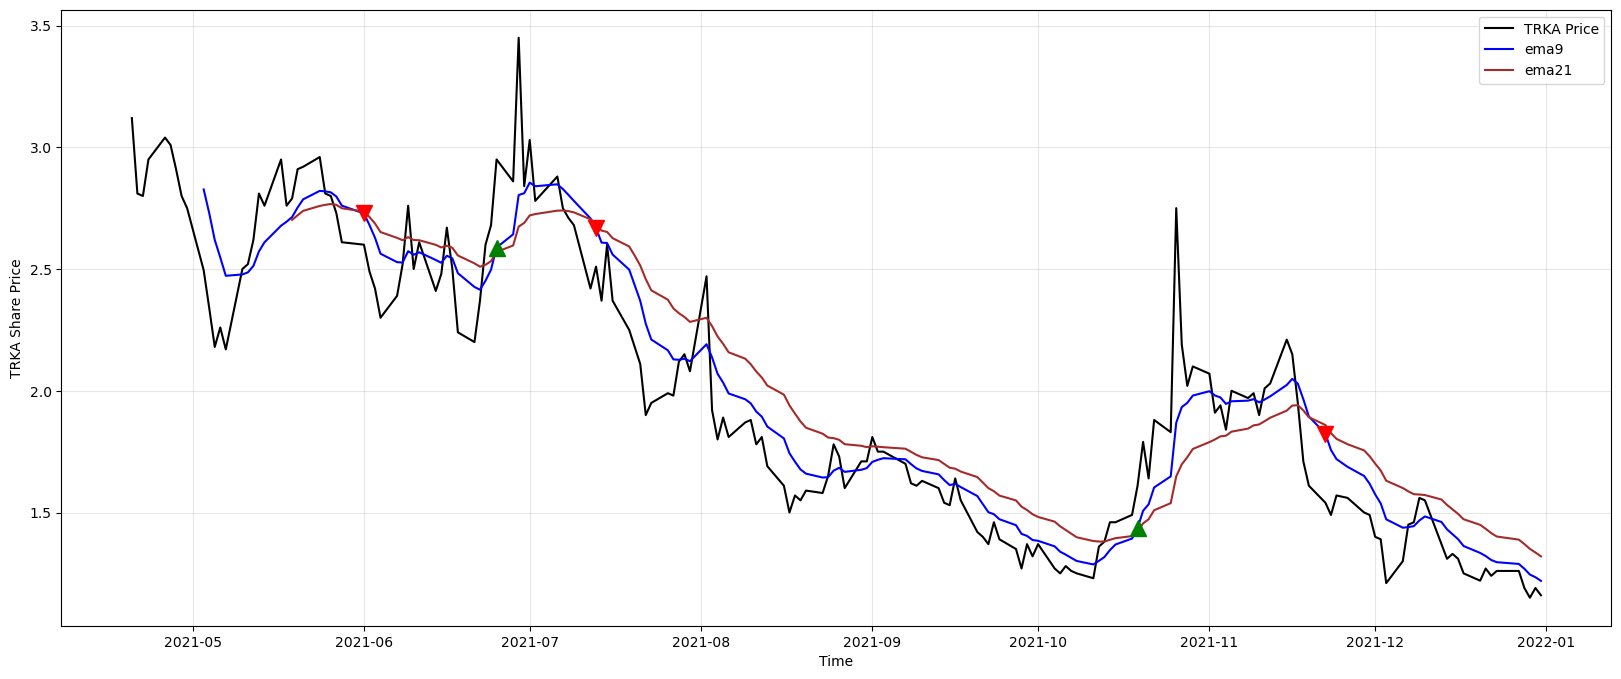

In [7]:
# Graph plots the stock closing prices with our MA functions and indicators for buy-in and exit/short positions

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.grid(True, alpha=0.3)
plt.plot(data['date'], data[price_type], color="black", label=f"{symbol} Price")
plt.plot(data['date'], data[f"{func_name}{nF}"], color="blue", label=f"{func_name}{nF}")
plt.plot(data['date'], data[f"{func_name}{nS}"], color="brown", label=f"{func_name}{nS}")
plt.plot(data['date'][data.entry == 2], data[f"{func_name}{nF}"][data.entry == 2], '^', color='green', markersize=12)
plt.plot(data['date'][data.entry == -2], data[f"{func_name}{nF}"][data.entry == -2], 'v', color='red', markersize=12)
plt.xlabel('Time')
plt.ylabel(f"{symbol} Share Price")
plt.legend()
plt.show()

In [ ]:
# Graph plots both the instanteous return and the system return

fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.plot(np.exp(data['return']).cumprod(), label="Buy/Hold")
plt.plot(np.exp(data['system_return']).cumprod(), label="System")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## 6. MACD Strategy
The MACD line is calculated by subtracting the 26-period EMA from the 12-period EMA.
The signal line is a nine-period EMA of the MACD line
- MACD triggers technical signals when the MACD line crosses above the signal line (buy)
- Or falls below the signal line (sell)
- Remember that point of entry or exit is at the cross point

In [ ]:
raw_data = initial_data()
try:
    raw_data['adj_close'][0]
    data = raw_data[['symbol','date','open_price','high_price','low_price','adj_close','volume']]
    price_type = 'adj_close'
except KeyError:
    data = raw_data[['symbol','date','open_price','high_price','low_price','close_price','volume']]
    price_type = 'close_price'

In [6]:
s = 2

x, ini_points = ma.ema(data[price_type], 12, len(data), s)
ema12 = [np.nan]*ini_points + x

y, ini_points = ma.ema(data[price_type], 26, len(data), s)
ema26 = [np.nan]*ini_points + y

ema12 = np.array(ema12)
ema26 = np.array(ema26)
MACD = ema12 - ema26

# Build the 9-period EMA of the MACD line -> So take the first 9 elements of the MACD to use as a SMA for the first EMA_9
# calculation on period 10 of the MACD. Then continue with normal EMA_9 
# Remember when we are calculating EMA OF MACD, the "Close_Price" is now the MACD price
signal = [np.nan]*35
sma = sum(MACD[26:35])/9
signal.append( (s/(9+1)) * (data[price_type][35] - sma) + sma )
for i in range(36, len(MACD)):
    signal.append( (s/(9+1)) * (MACD[i] - signal[i-1]) + signal[i-1] )
    
histogram = MACD - signal


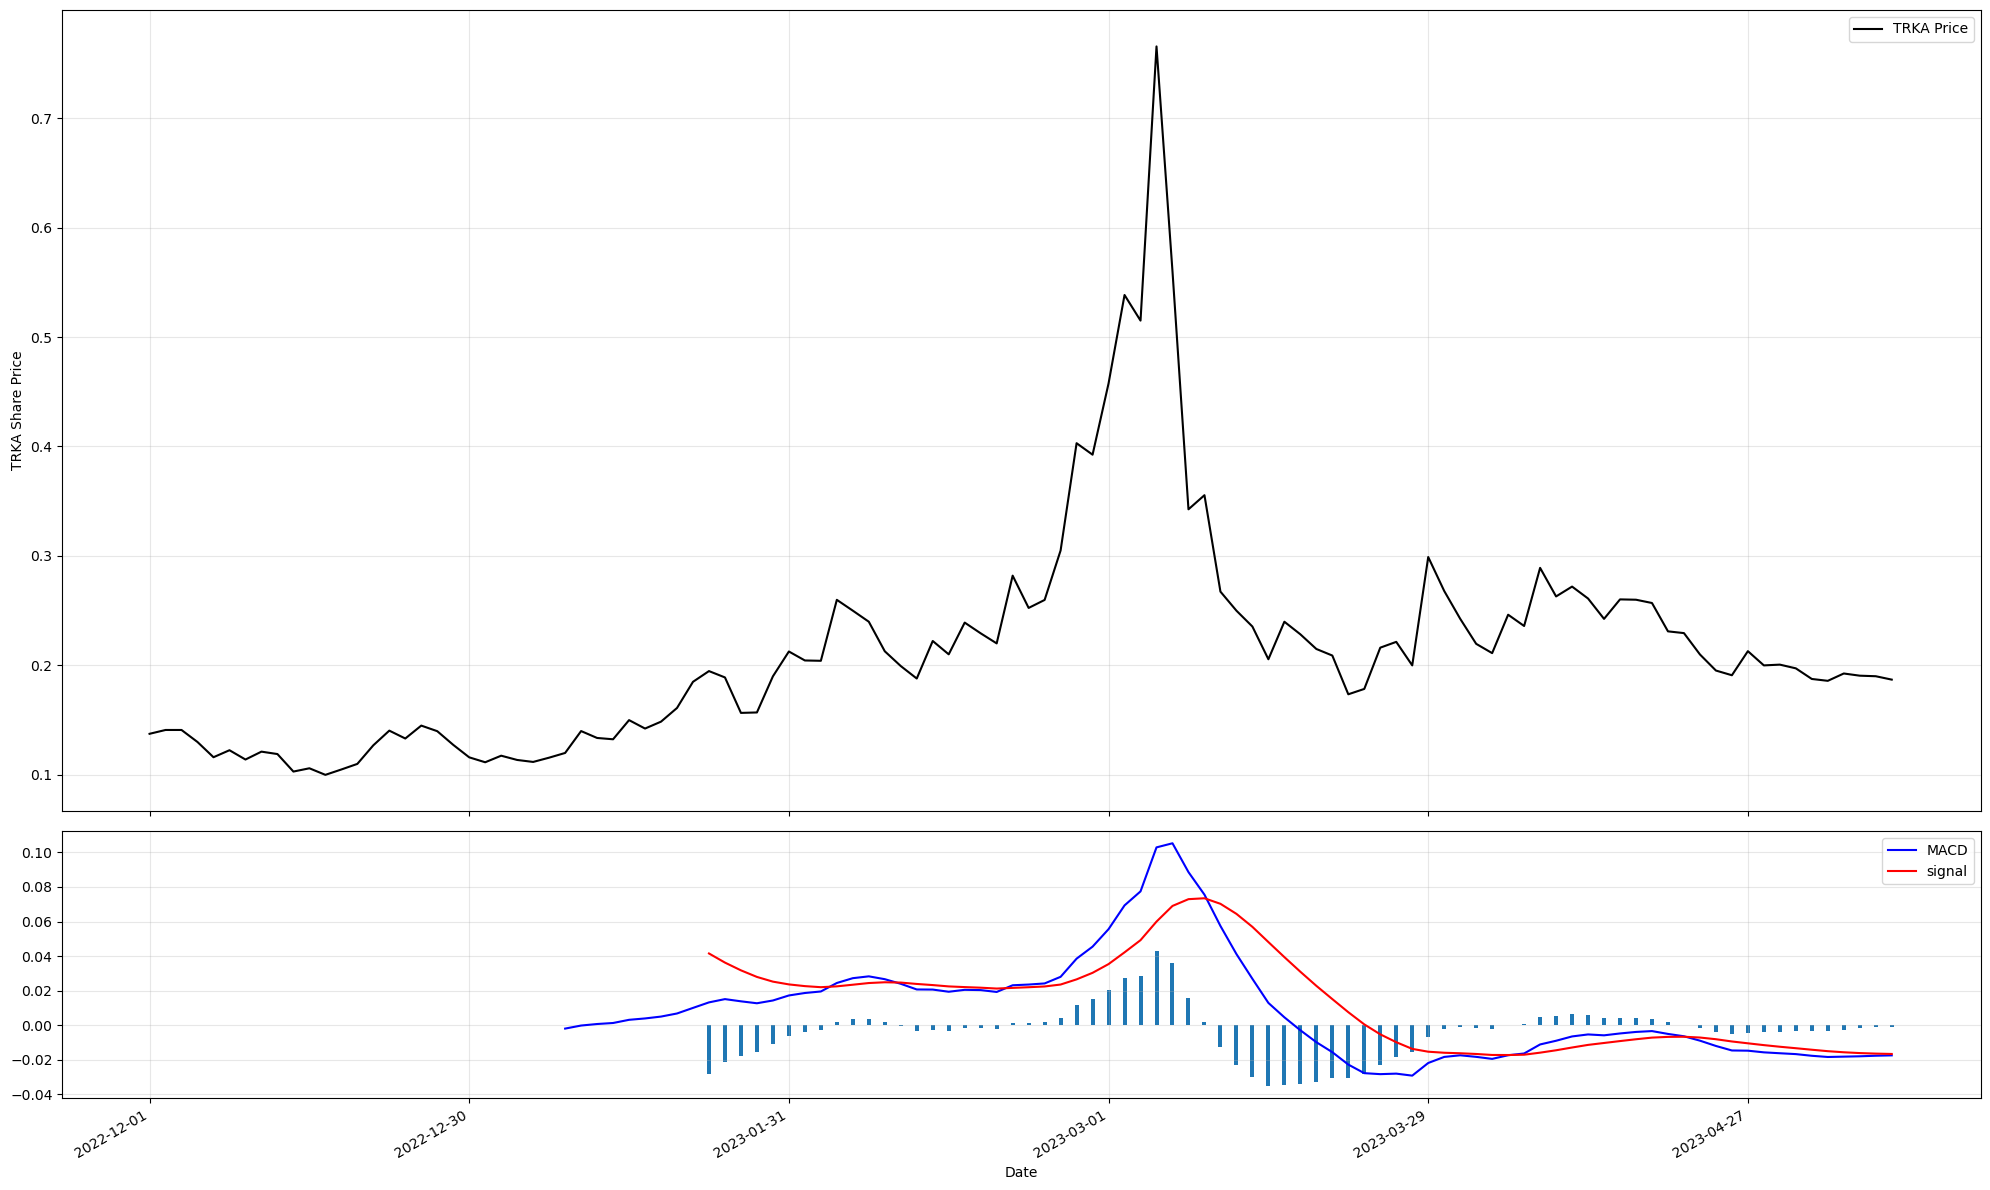

In [7]:
x_val = np.arange(len(data))

fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(12)
ax1.grid(True, alpha=0.3)
ax2.grid(True, alpha=0.3)

ax1.plot(x_val, data[price_type], color="black", label=f"{symbol} Price")
ax1.set_xlabel('Time')
ax1.set_ylabel(f"{symbol} Share Price")
ax1.legend()
equidate_ax(fig, ax1, data['date'])

ax2.plot(x_val, MACD, color="blue", label="MACD")
ax2.plot(x_val, signal, color='red', label='signal')
ax2.bar(x_val, histogram, width = 0.25)
ax2.legend()
equidate_ax(fig, ax2, data['date'])

fig.tight_layout()